In [1]:
# LOAD LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# GLOBAL VARIABLES
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

2022-03-15 21:42:26.954927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 21:42:26.955020: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# evaluate the deep model on the test dataset
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
 
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

x_train, y_train, x_valid, y_valid = load_dataset()
x_train, x_valid = prep_pixels(x_train, x_valid)

In [3]:
model = Sequential()
model.add(Conv2D(32,kernel_size=4,activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=4,activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

2022-03-15 21:42:45.474224: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-15 21:42:45.474288: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-15 21:42:45.474339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (paula-Inspiron-3459): /proc/driver/nvidia/version does not exist
2022-03-15 21:42:45.475968: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import sys
  
sys.path.insert(0, '../')

from ipynb.fs.full.utils import save_weights, evaluate_layers_sensitivity, prune_layer_feature_maps

In [7]:
save_weights("arm_model.txt", model)

# Training Model

In [5]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, verbose=1, validation_data=(x_valid, y_valid))

2022-03-15 21:43:05.593037: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/5
1875/1875 [==============================] - 35s 18ms/step - loss: 0.1177 - accuracy: 0.9644 - val_loss: 0.0385 - val_accuracy: 0.9880
Epoch 2/5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0414 - accuracy: 0.9877 - val_loss: 0.0467 - val_accuracy: 0.9865
Epoch 3/5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0303 - accuracy: 0.9909 - val_loss: 0.0263 - val_accuracy: 0.9916
Epoch 4/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.0430 - val_accuracy: 0.9884
Epoch 5/5
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0201 - accuracy: 0.9944 - val_loss: 0.0314 - val_accuracy: 0.9916


In [6]:
model.predict(x_valid[0:1])

array([[1.8308471e-14, 7.1959712e-13, 1.9727253e-09, 2.3658568e-13,
        1.4433642e-17, 1.0557437e-14, 1.6097974e-23, 1.0000000e+00,
        9.3137032e-16, 9.7722273e-12]], dtype=float32)

In [28]:
y_valid[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [29]:
model.summary()

Model: "sequential_563"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_785 (Conv2D)         (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_785 (MaxPooli  (None, 12, 12, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_786 (Conv2D)         (None, 9, 9, 64)          32832     
                                                                 
 max_pooling2d_786 (MaxPooli  (None, 4, 4, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_563 (Flatten)       (None, 1024)              0         
                                                                 
 dense_1126 (Dense)          (None, 128)            

## Prunning

layer: 0
remove: 1
313/313 [==============================] - 2s 5ms/step - loss: 0.0302 - accuracy: 0.9906
remove: 4
313/313 [==============================] - 2s 5ms/step - loss: 0.0288 - accuracy: 0.9911
remove: 7
313/313 [==============================] - 2s 4ms/step - loss: 0.0272 - accuracy: 0.9912
remove: 10
313/313 [==============================] - 2s 5ms/step - loss: 0.0292 - accuracy: 0.9907
remove: 13
313/313 [==============================] - 1s 4ms/step - loss: 0.0412 - accuracy: 0.9875
remove: 16
313/313 [==============================] - 1s 4ms/step - loss: 0.0699 - accuracy: 0.9808
remove: 19
313/313 [==============================] - 1s 4ms/step - loss: 0.0771 - accuracy: 0.9789
remove: 22
313/313 [==============================] - 1s 4ms/step - loss: 0.2120 - accuracy: 0.9429
remove: 25
313/313 [==============================] - 1s 4ms/step - loss: 0.6875 - accuracy: 0.7863
remove: 28
313/313 [==============================] - 1s 4ms/step - loss: 1.9528 - accuracy: 0

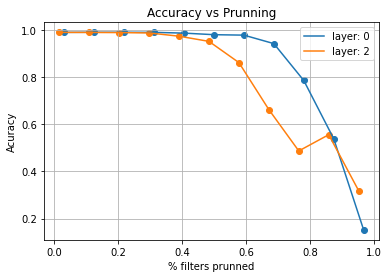

In [30]:
evaluate_layers_sensitivity(model, x_valid, y_valid)

In [39]:
# Prune first layer
model_prunned = prune_layer_feature_maps(model, 0, 22)
model_prunned.compile(loss = "categorical_crossentropy", metrics = ["accuracy"])
_, _ = model_prunned.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.2120 - accuracy: 0.9429


In [40]:
# retrain
_ = model_prunned.fit(x_train, y_train, epochs=3, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.0582 - val_accuracy: 0.9825
Epoch 2/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0355 - val_accuracy: 0.9911
Epoch 3/3
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0149 - accuracy: 0.9959 - val_loss: 0.0376 - val_accuracy: 0.9912


In [41]:
# Prune second layer
model_prunned_2 = prune_layer_feature_maps(model_prunned, 2, 37)
model_prunned_2.compile(loss = "categorical_crossentropy", metrics = ["accuracy"])
_, _ = model_prunned_2.evaluate(x_valid,  y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.0944 - accuracy: 0.9698


In [42]:
# retrain
_ = model_prunned_2.fit(x_train, y_train, epochs=3, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/3
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0232 - accuracy: 0.9929 - val_loss: 0.0296 - val_accuracy: 0.9909
Epoch 2/3
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0177 - accuracy: 0.9947 - val_loss: 0.0319 - val_accuracy: 0.9897
Epoch 3/3
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.0483 - val_accuracy: 0.9902


In [43]:
model_prunned_2.summary()

Model: "sequential_1204"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1609 (Conv2D)        (None, 25, 25, 10)        170       
                                                                 
 max_pooling2d_1609 (MaxPool  (None, 12, 12, 10)       0         
 ing2D)                                                          
                                                                 
 conv2d_1647 (Conv2D)        (None, 9, 9, 27)          4347      
                                                                 
 max_pooling2d_1647 (MaxPool  (None, 4, 4, 27)         0         
 ing2D)                                                          
                                                                 
 flatten_1204 (Flatten)      (None, 432)               0         
                                                                 
 dense_2408 (Dense)          (None, 128)           

In [44]:
model_prunned_2.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 4ms/step - loss: 0.0483 - accuracy: 0.9902


[0.04830210655927658, 0.9901999831199646]

In [45]:
model.evaluate(x_valid, y_valid)

313/313 [==============================] - 1s 5ms/step - loss: 0.0302 - accuracy: 0.9906


[0.030174149200320244, 0.9905999898910522]

In [46]:
save_weights("prunned_arm_model.orga", model_prunned_2)